In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, gennorm
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
wti = yf.download('CL=F', start='2000-01-01', end='2023-12-31')
wti['Date'] = pd.to_datetime(wti.index)
wti['Year'] = wti['Date'].dt.year
wti = wti.set_index('Date')   
wti['Daily_Return'] = wti['Adj Close'].pct_change()
wti['Log_Return'] = np.log(wti['Adj Close']).diff()

[*********************100%%**********************]  1 of 1 completed


In [3]:
wti.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Year,Daily_Return,Log_Return
Date,,,,,,,,,
2023-12-15,71.610001,72.220001,70.300003,71.430000,71.430000,95513,2023,-0.002096,-0.002098
2023-12-18,71.680000,74.260002,70.639999,72.470001,72.470001,73941,2023,0.014560,0.014455
2023-12-19,72.480003,74.010002,71.849998,73.440002,73.440002,230042,2023,0.013385,0.013296
2023-12-20,74.059998,75.370003,73.599998,74.220001,74.220001,273364,2023,0.010621,0.010565
2023-12-21,73.809998,74.580002,72.440002,73.889999,73.889999,251982,2023,-0.004446,-0.004456
2023-12-22,73.910004,74.980003,73.389999,73.559998,73.559998,222600,2023,-0.004466,-0.004476
2023-12-26,73.559998,76.180000,73.129997,75.570000,75.570000,208715,2023,0.027325,0.026958
2023-12-27,75.320000,75.660004,73.769997,74.110001,74.110001,253323,2023,-0.019320,-0.019509
2023-12-28,73.800003,74.400002,71.720001,71.769997,71.769997,262748,2023,-0.031575,-0.032084


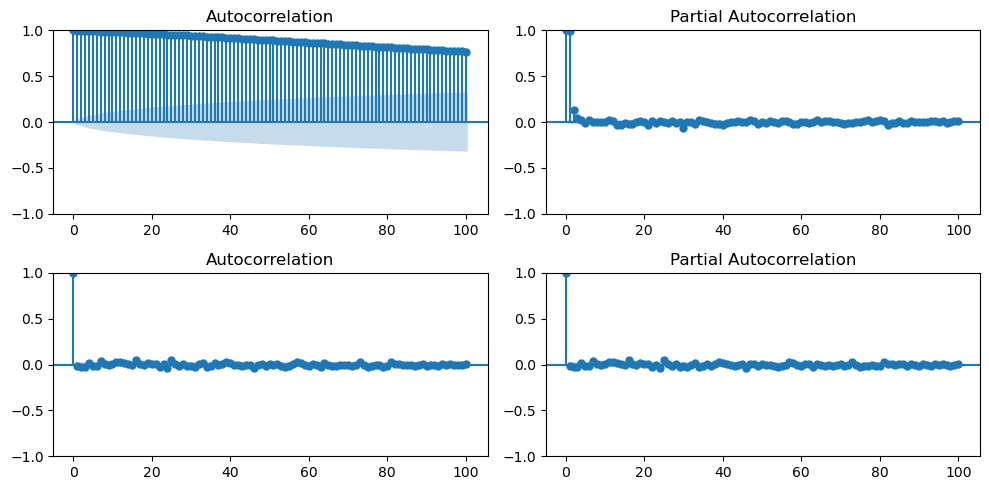

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
plot_acf(wti['Close'].dropna(), ax=axs[0,0], lags=100)
plot_pacf(wti['Close'].dropna(), ax=axs[0,1], lags=100)
plot_acf(wti['Log_Return'].dropna(), ax=axs[1,0], lags=100)
plot_pacf(wti['Log_Return'].dropna(), ax=axs[1,1], lags=100)
plt.tight_layout(); plt.show()

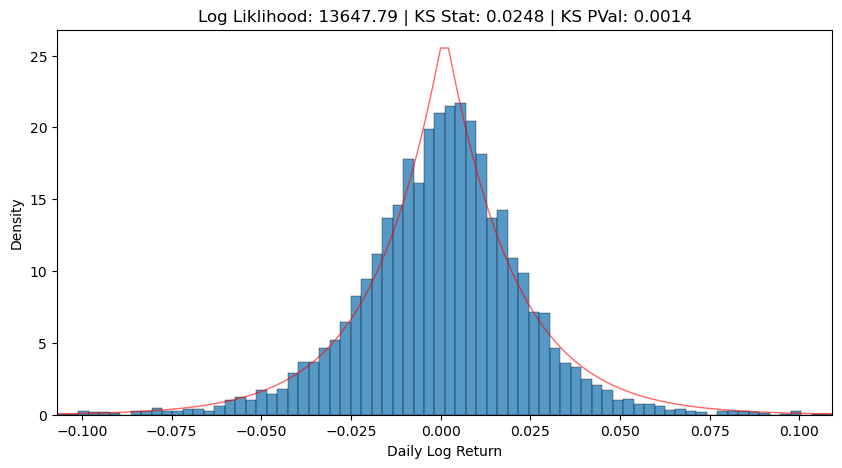

In [5]:
params = gennorm.fit(wti['Log_Return'].dropna())
log_likelihood = gennorm.logpdf(wti['Log_Return'].dropna(), *params).sum()
ks_stat, ks_stat_pval = kstest(wti['Log_Return'].dropna(), 'gennorm', params)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(wti['Log_Return'].dropna(), kde=False, stat='density', ax=ax)
x = np.linspace(gennorm.ppf(0.001, params[0], params[1], params[2]), 
                    gennorm.ppf(0.999, params[0], params[1], params[2]), 
                    100)
ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
ax.set(title=f'Log Liklihood: {log_likelihood:.2f} | KS Stat: {ks_stat:.4f} | KS PVal: {ks_stat_pval:.4f}',
       xlabel='Daily Log Return', ylabel='Density', xlim=(np.min(x), np.max(x)))
plt.show()  

In [ ]:
# dataframe to save lagsize scores
scores_by_lag = pd.DataFrame(index=years, columns=range(1,6))

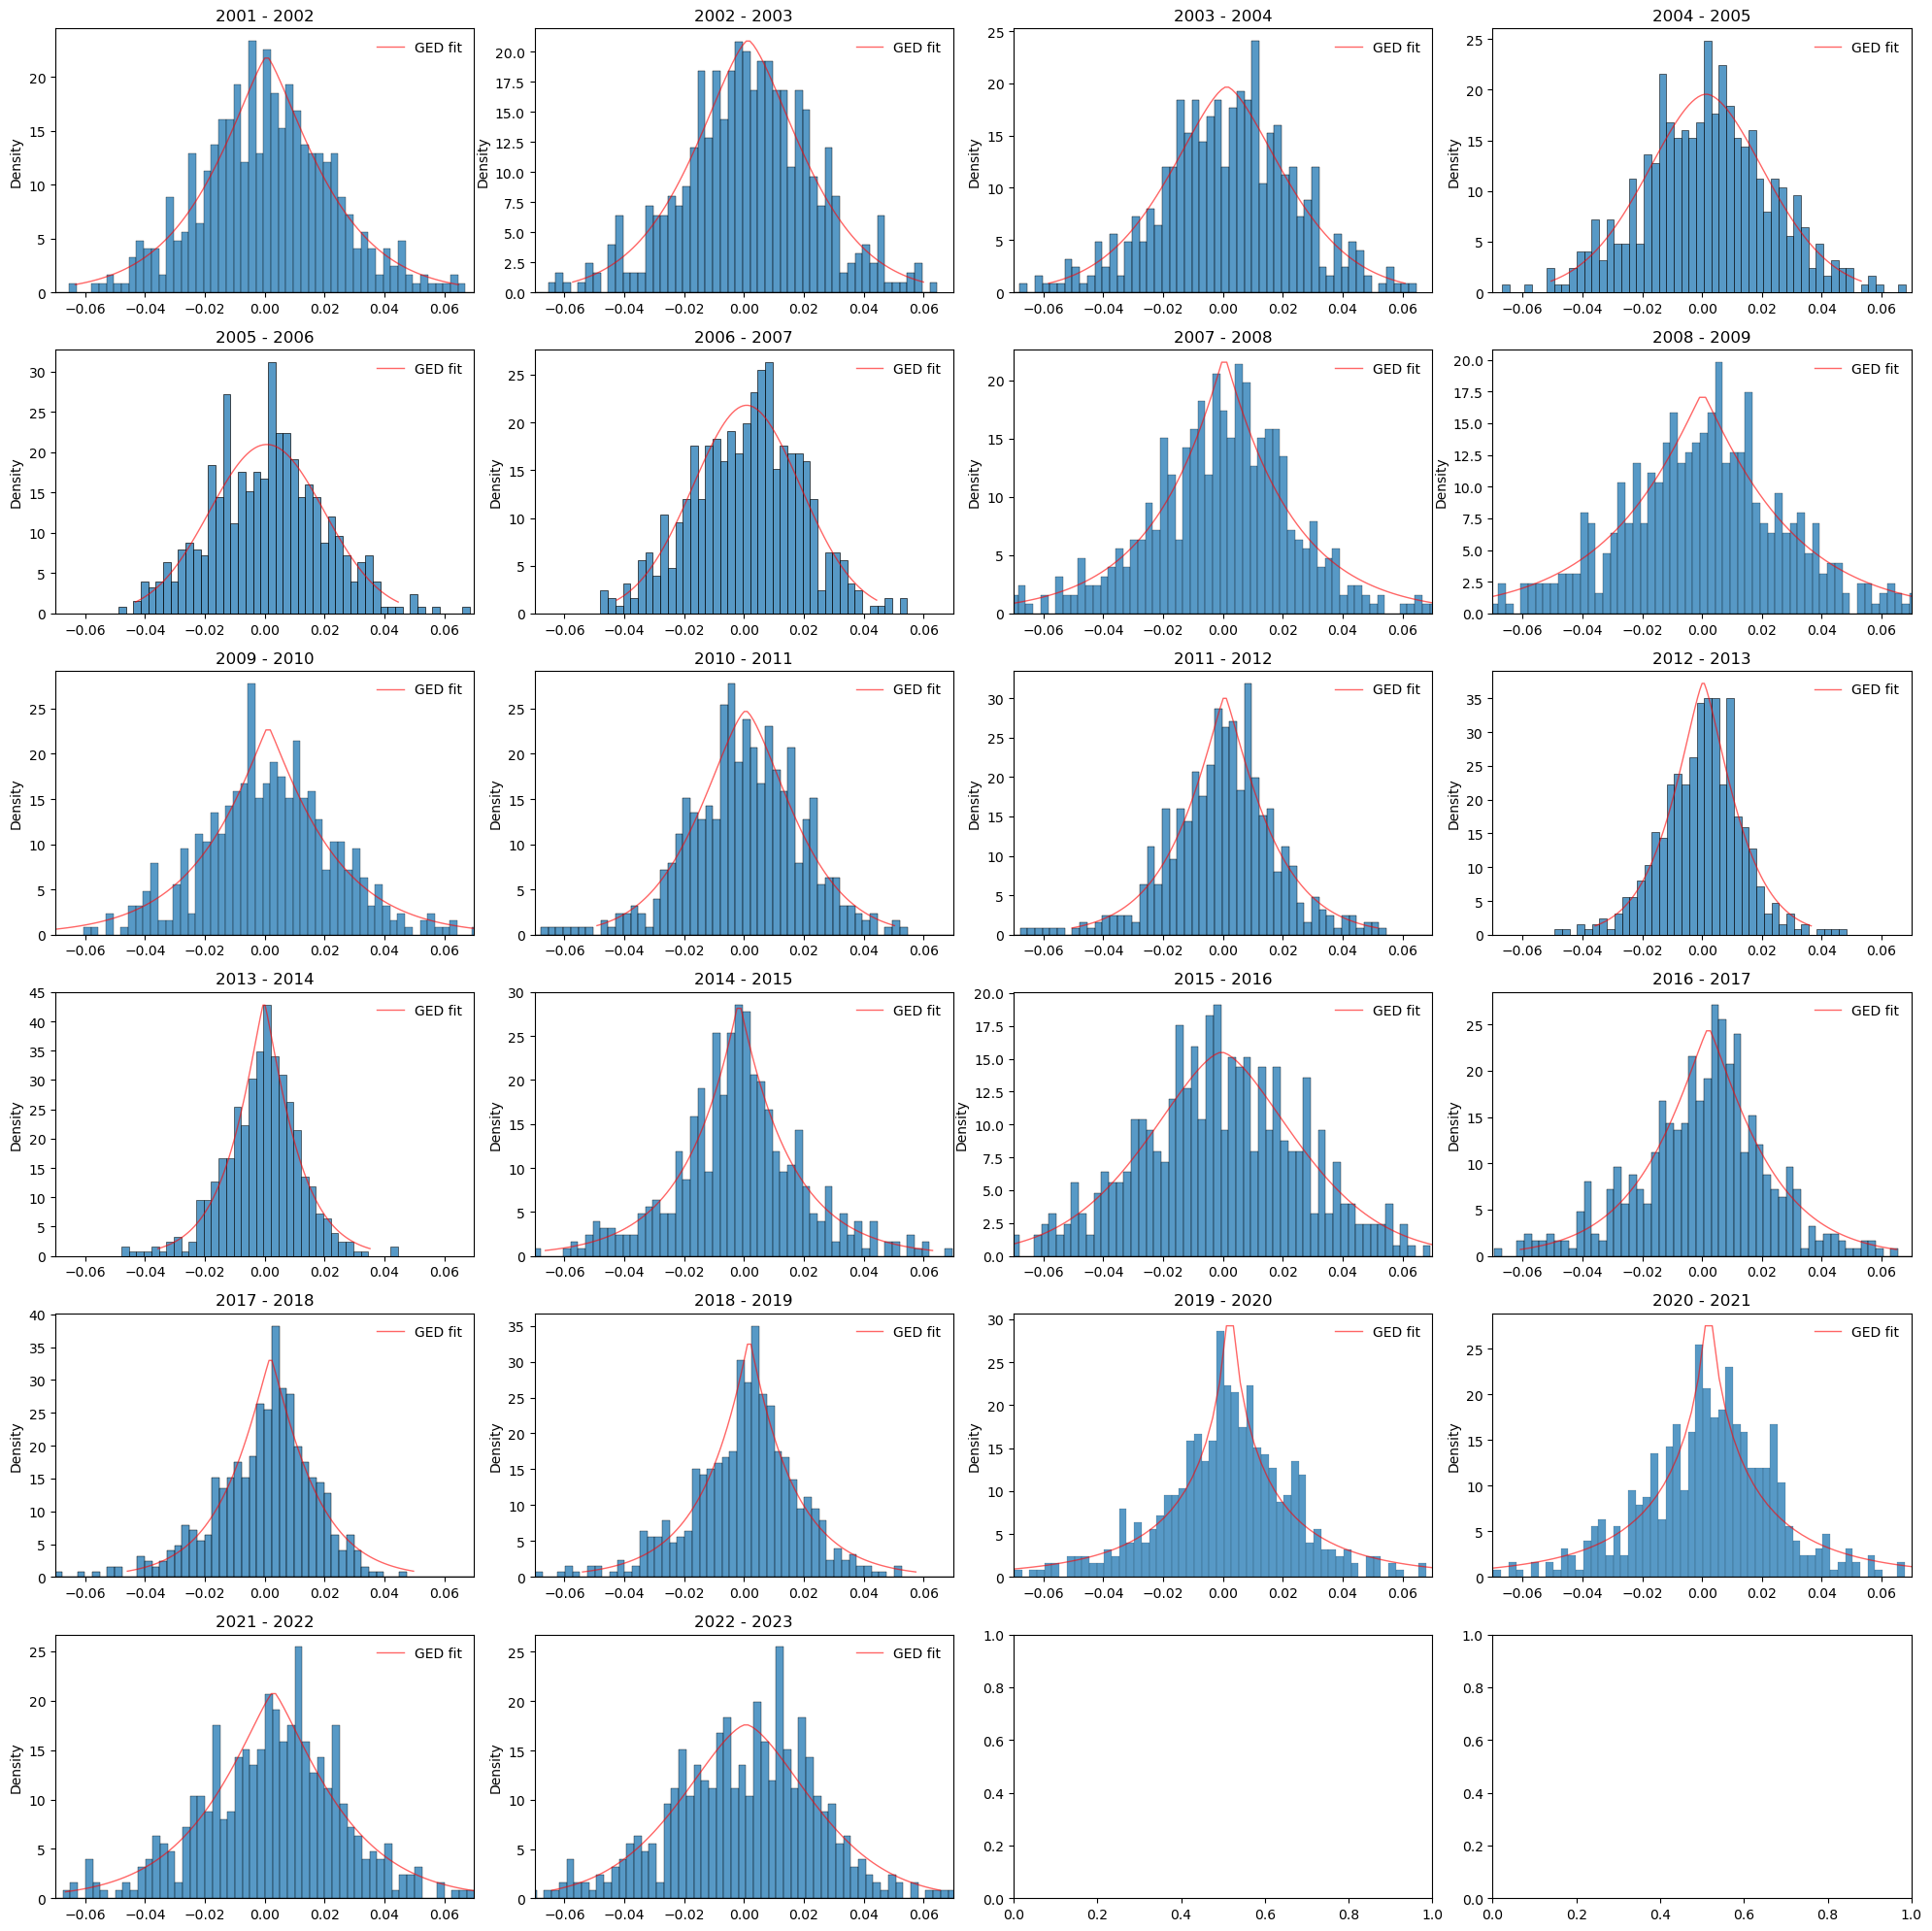

In [88]:
years = wti['Year'].unique()
window_size_years = 2
distributions = pd.DataFrame(index=years, columns=['Beta', 'Loc', 'Scale', 
                                                   'Median', 'Mean', 'Std',
                                                   'Log_Likelihood', 'KS_Stat', 'KS_Pval']) 
fig, axs = plt.subplots(nrows=(len(years)+1)//4, ncols=4, figsize=(20, 20))
for i, y in enumerate(years[window_size_years:]):
    ax = axs[i//4, i%4]
    label = f'{y - window_size_years + 1} - {y}'
    data = wti.loc[(wti['Year'] > y - window_size_years) & (wti['Year'] < y + 1), 'Log_Return']
    data = np.where((data == np.inf) | (data == -np.inf), np.nan, data)
    data = data[~np.isnan(data)]
    params = gennorm.fit(data)
    log_likelihood = gennorm.logpdf(data, beta=params[0], loc=params[1], scale=params[2]).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(params[0], params[1], params[2]))
    distributions.loc[y] = [params[0], params[1], params[2],
                            np.median(data), np.mean(data), np.std(data),
                            log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=ax, stat='density', binwidth=0.0025)
    x = np.linspace(gennorm.ppf(0.01, params[0], params[1], params[2]), 
                    gennorm.ppf(0.99, params[0], params[1], params[2]), 
                    100)
    ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
    ax.set(title=label, xlim=(-0.07, 0.07))  
    ax.legend(loc='best', frameon=False)
plt.tight_layout(); plt.show()
    
    

In [89]:
distributions

,Beta,Loc,Scale,Median,Mean,Std,Log_Likelihood,KS_Stat,KS_Pval
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,1.284487,0.000634,0.024593,0.000709,0.000306,0.024959,1148.393123,0.02353,0.939904
2003,1.451671,0.001395,0.026301,0.001427,0.000988,0.02333,1177.104925,0.026759,0.8568
2004,1.521679,0.001276,0.02818,0.00222,0.000664,0.023985,1159.095527,0.032235,0.665292
2005,1.787683,0.001334,0.028733,0.001909,0.001259,0.021671,1207.088328,0.019523,0.98927
2006,2.025684,0.000679,0.026944,0.00165,0.000679,0.018928,1276.642692,0.031866,0.676818
2007,1.949066,0.000927,0.025874,0.002084,0.000902,0.018547,1289.416217,0.028509,0.798174
2008,1.03966,0.000418,0.022828,0.000419,-0.000622,0.030907,1080.898797,0.036276,0.507986
2009,1.091238,0.000161,0.029593,0.000272,-0.000377,0.03676,981.595739,0.022953,0.947321


In [90]:
simulations = pd.DataFrame(index=years, columns=['Sim_Pct_Return', 'Sum_Cum_Return', 'Sim_Prices'])
for y in years[window_size_years+1:]:
    last_price = wti.loc[(wti['Year'] == y-1), 'Close'].iloc[-1]
    log_return = gennorm.rvs(beta=distributions.loc[y-1, 'Beta'], 
                             loc=distributions.loc[y-1, 'Loc'],
                             scale=distributions.loc[y-1, 'Scale'],
                             size=(wti.loc[(wti['Year'] == y), 'Close'].shape[0], 1000)) 
    cum_return = np.cumsum(log_return, axis=0)
    sim_prices = last_price * np.exp(cum_return)
    simulations.loc[y] = [log_return, cum_return, sim_prices]
    pass
    

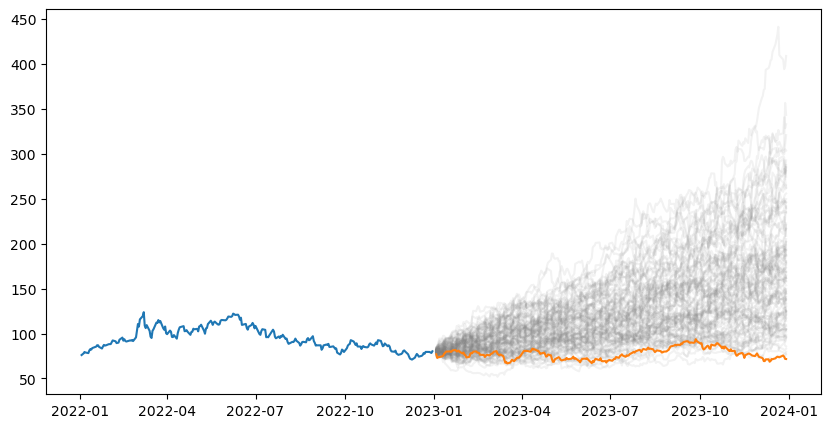

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(wti.loc[(wti['Year'] == 2022), 'Close'], label='Prior Year')
for i in range(100):
    ax.plot(wti.loc[(wti['Year'] == 2023), 'Close'].index, sim_prices[:, i], '-', c='gray', alpha=0.1)
ax.plot(wti.loc[(wti['Year'] == 2023), 'Close'], label='Actual')
plt.show()

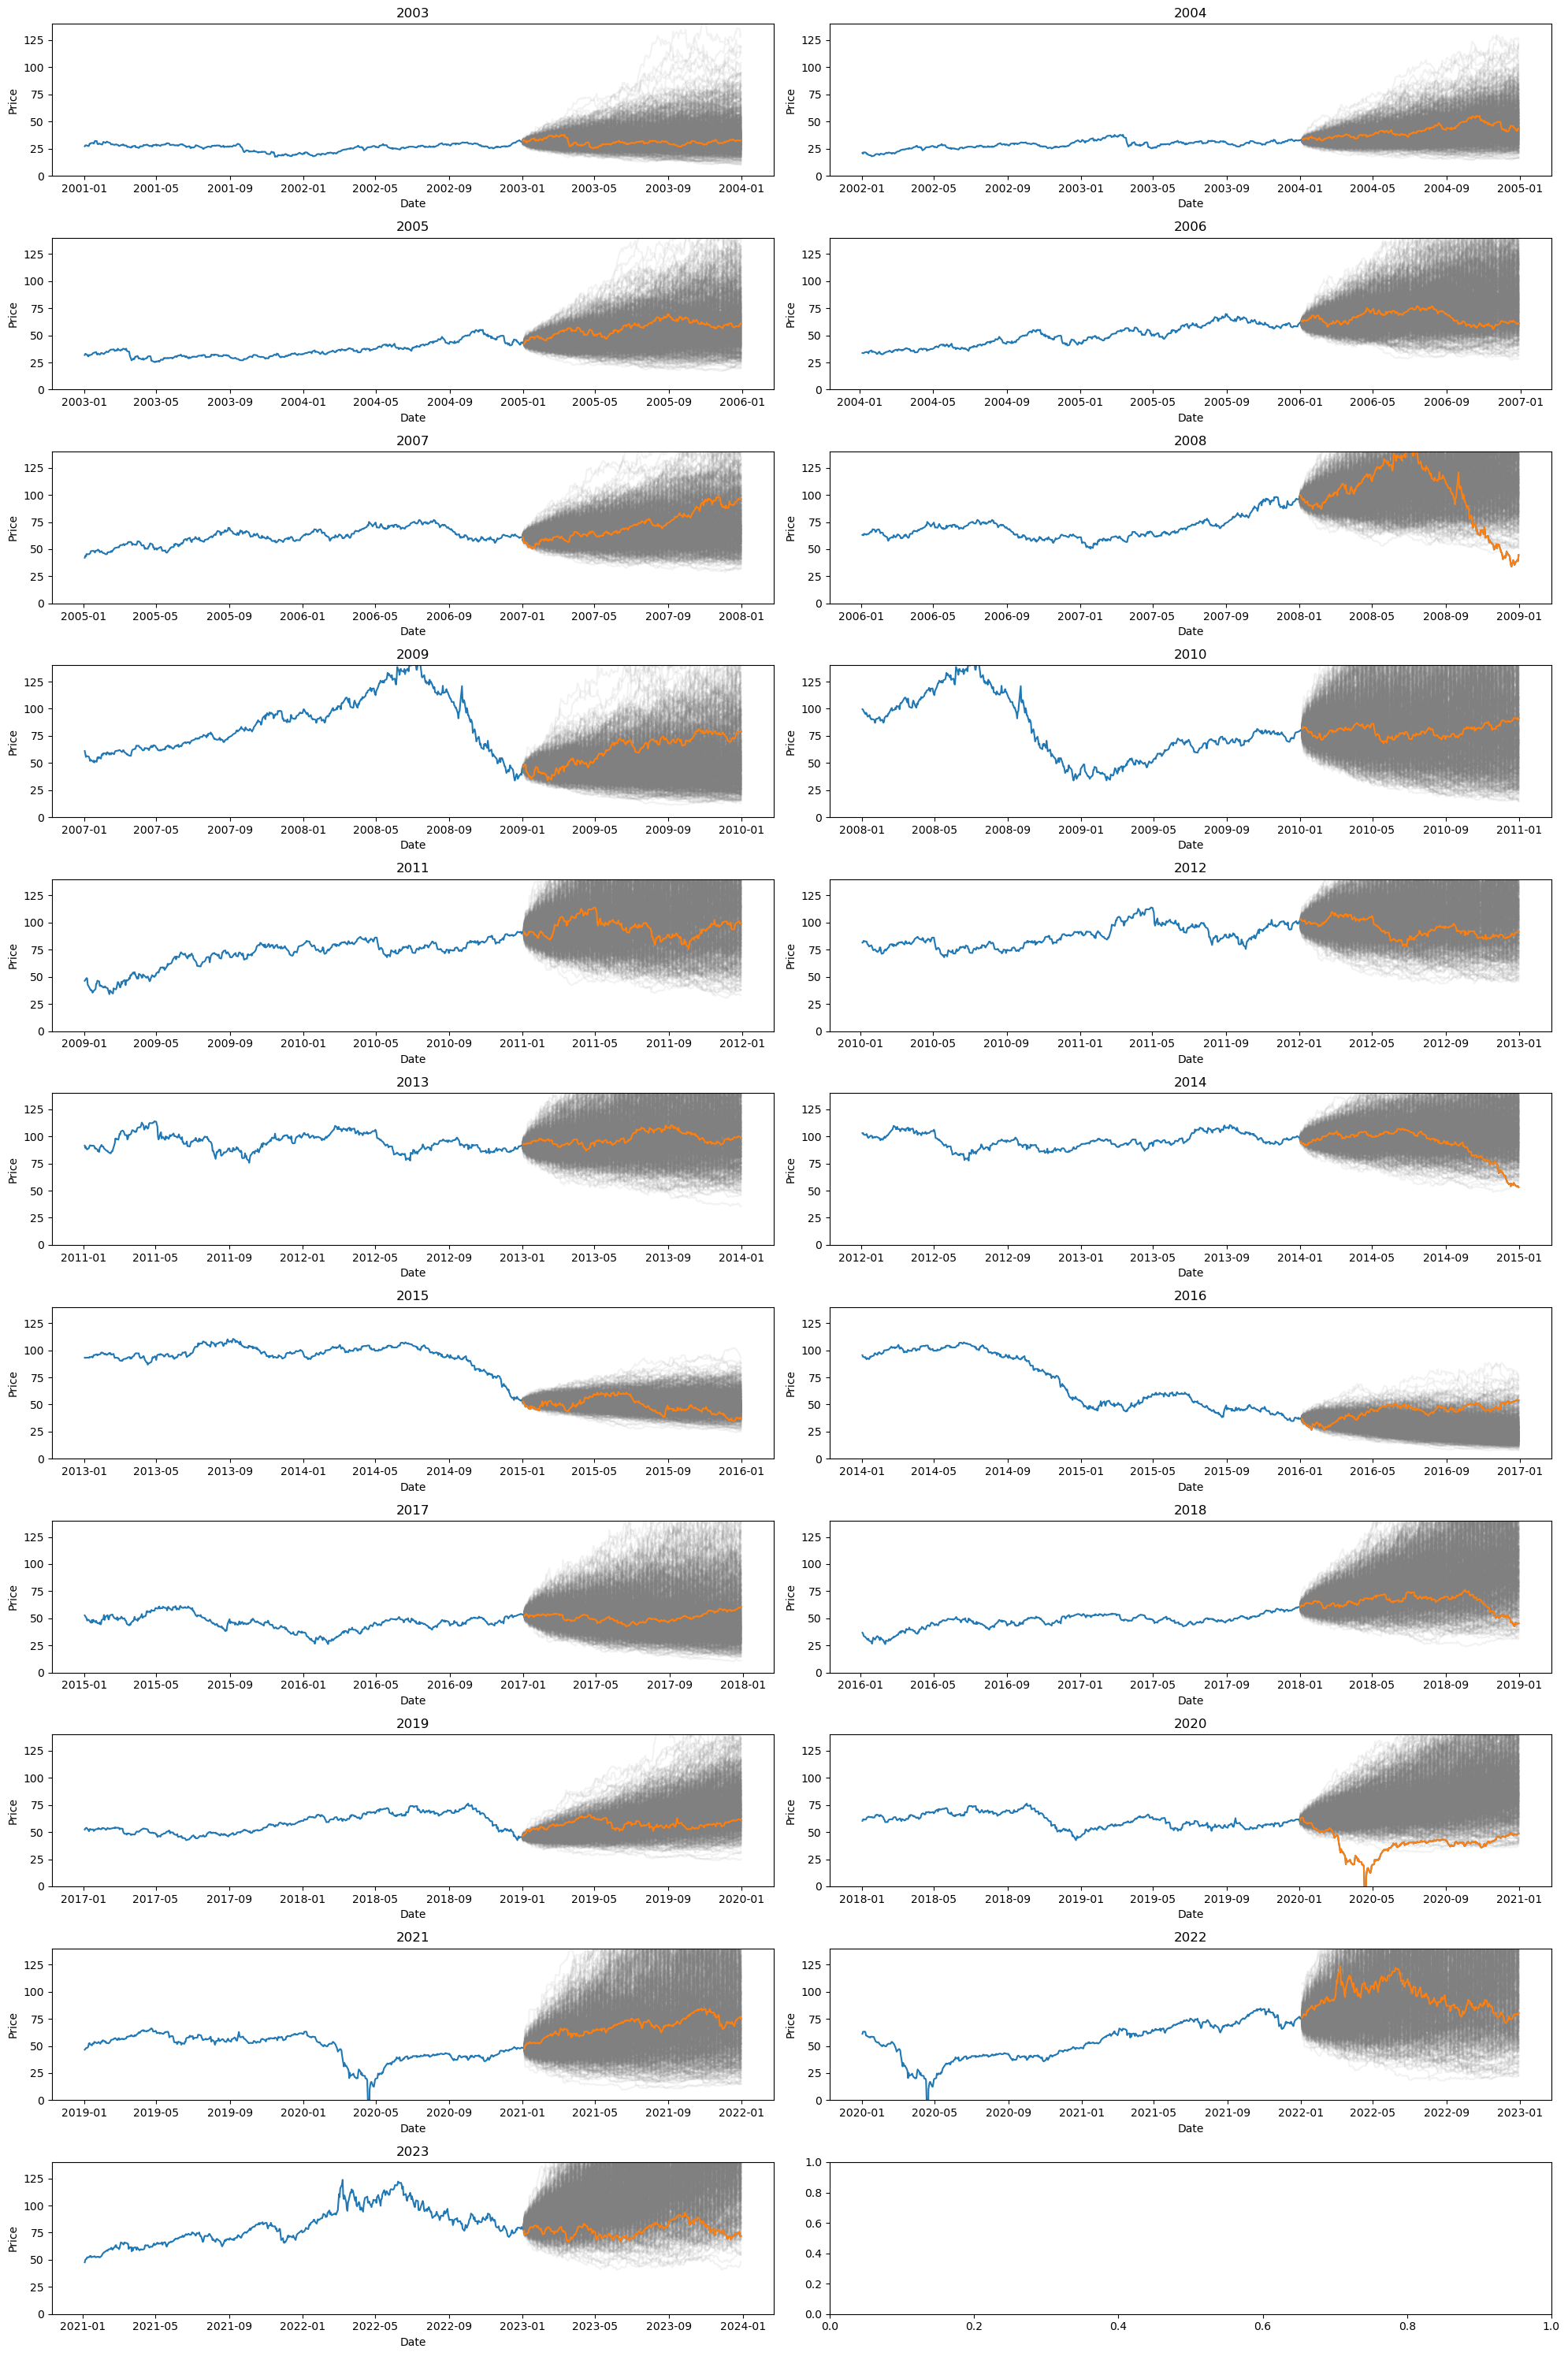

In [98]:
fig, axs = plt.subplots(nrows=(len(years[window_size_years:]))//2, ncols=2, figsize=(20, 30))
for i, y in enumerate(years[window_size_years+1:]):
    ax = axs[i//2, i%2]
    ax.plot(wti.loc[(wti['Year'] >= y - window_size_years) & (wti['Year'] < y + 1), 'Close'], label='Prior Year')
    for i in range(1000):
        ax.plot(wti.loc[(wti['Year'] == y), 'Close'].index, simulations.loc[y, 'Sim_Prices'][:, i], '-', c='gray', alpha=0.1)
    ax.plot(wti.loc[(wti['Year'] == y), 'Close'], label='Actual')
    ax.set(title=y, xlabel='Date', ylabel='Price', ylim=(0,140))
plt.tight_layout(); plt.show()

In [93]:
confidence_intervals = np.arange(1, 100, 1)
ci_scores = pd.DataFrame(index=years, columns=confidence_intervals)
for y in years[window_size_years+1:]:
    actual = wti.loc[(wti['Year'] == y), 'Close']
    trading_days = actual.shape[0]
    sim_prices = simulations.loc[y, 'Sim_Prices']
    scores = []
    for ci in confidence_intervals:
        lower_bound = np.percentile(sim_prices, 50 - (ci / 2), axis=1)
        upper_bound = np.percentile(sim_prices, 50 + (ci / 2), axis=1)
        score = np.logical_and(lower_bound < actual, actual < upper_bound).sum() / trading_days
        scores.append(score)
    ci_scores.loc[y] = scores

scores = []
for row in ci_scores.dropna().iterrows():
    ci_intervals = row[1].index / 100   
    indicator = (row[1].values >= ci_intervals).astype(int)
    goodness = 1 - (3 * indicator - 2) * (row[1].values - ci_intervals)
    piecewise = np.trapz(y=goodness, x=ci_intervals)
    scores.append(piecewise)

In [94]:
ci_scores.loc[years[window_size_years+1:], :]

,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
2003,0.0,0.0,0.0,0.0,0.004,0.008,0.008,0.008,0.008,0.008,...,0.996,0.996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2004,0.036145,0.056225,0.076305,0.092369,0.104418,0.124498,0.128514,0.148594,0.184739,0.220884,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2005,0.031873,0.067729,0.095618,0.103586,0.115538,0.135458,0.143426,0.159363,0.179283,0.187251,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2006,0.032,0.076,0.104,0.12,0.148,0.172,0.216,0.244,0.268,0.304,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2007,0.027778,0.039683,0.051587,0.059524,0.087302,0.111111,0.119048,0.130952,0.150794,0.150794,...,0.940476,0.944444,0.948413,0.948413,0.948413,0.952381,0.956349,0.960317,0.964286,0.97619
2008,0.011858,0.027668,0.039526,0.055336,0.063241,0.075099,0.086957,0.098814,0.098814,0.098814,...,0.782609,0.782609,0.782609,0.790514,0.790514,0.790514,0.802372,0.818182,0.837945,0.857708
2009,0.011905,0.015873,0.019841,0.019841,0.02381,0.02381,0.027778,0.031746,0.031746,0.031746,...,0.968254,0.972222,0.97619,0.980159,0.984127,0.992063,0.996032,0.996032,0.996032,1.0
2010,0.043651,0.119048,0.154762,0.206349,0.265873,0.31746,0.357143,0.400794,0.452381,0.503968,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2011,0.003968,0.011905,0.015873,0.035714,0.043651,0.06746,0.079365,0.087302,0.09127,0.103175,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2012,0.02,0.032,0.064,0.084,0.096,0.116,0.12,0.12,0.132,0.144,...,0.996,0.996,0.996,0.996,0.996,0.996,1.0,1.0,1.0,1.0


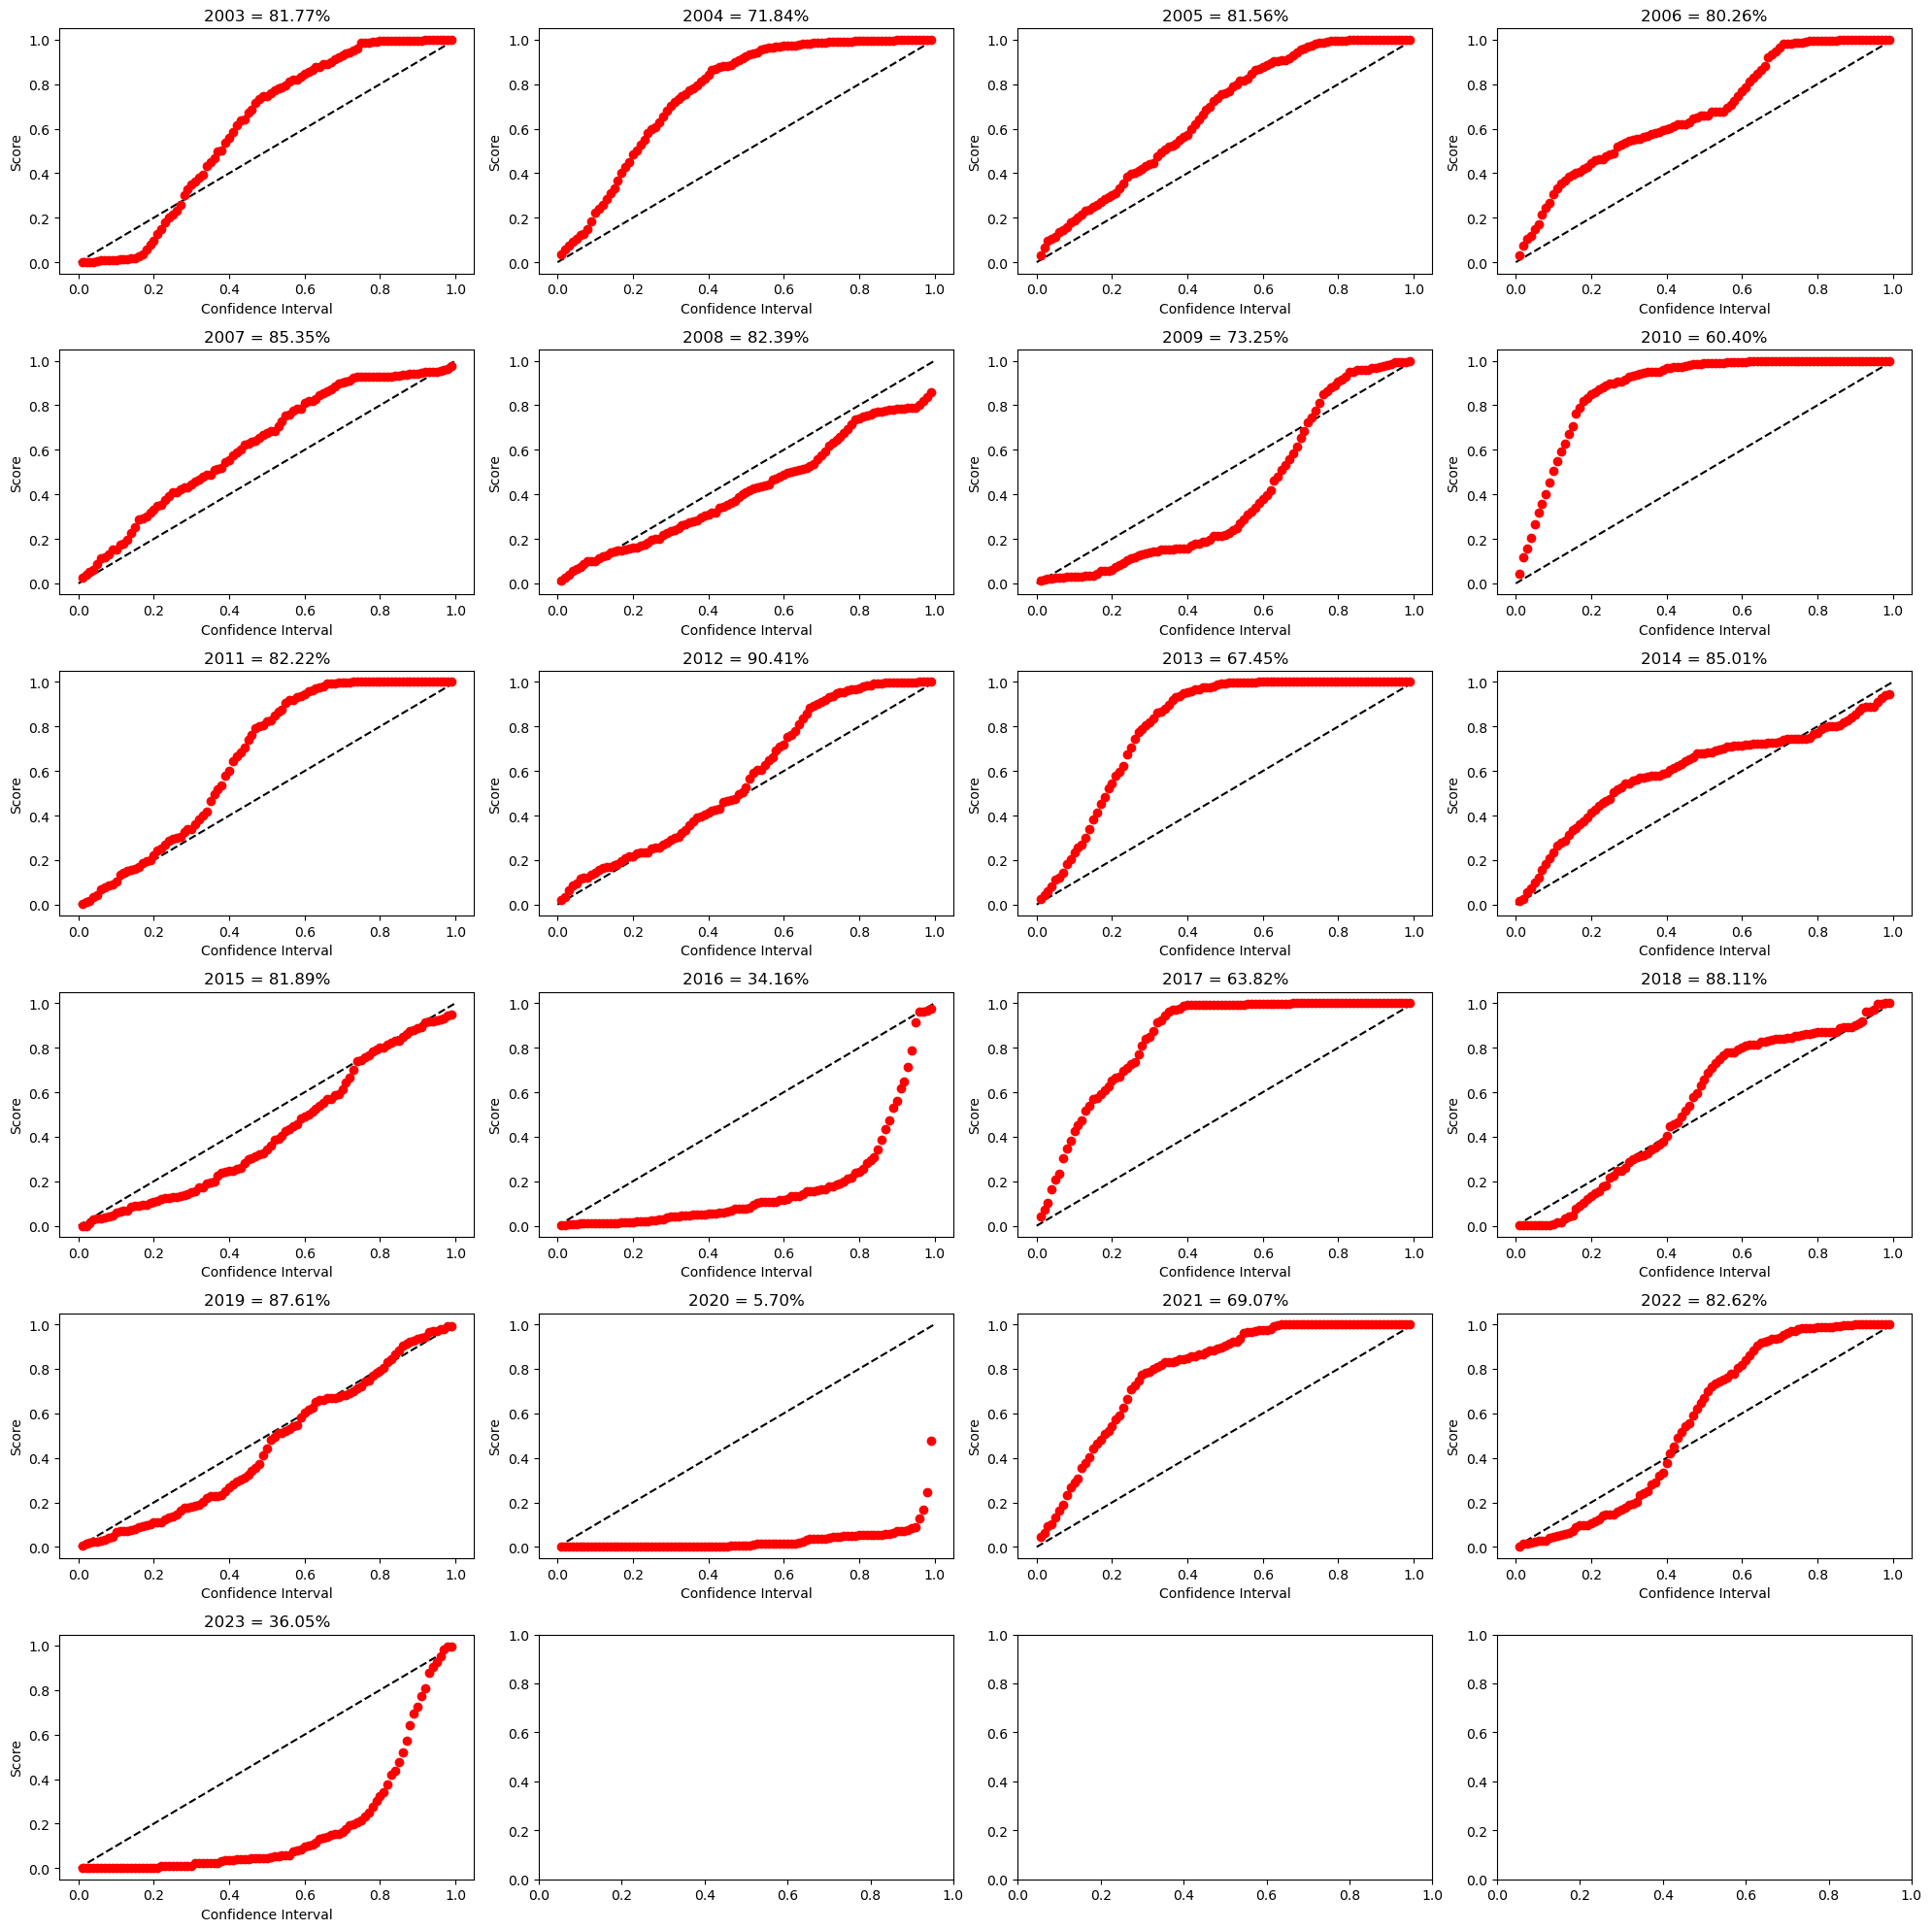

In [95]:
fig, axs = plt.subplots(nrows=len(years)//4, ncols=4, figsize=(20, 20))
for i, y in enumerate(years[window_size_years+1:]):
    ax = axs[i//4, i%4]
    ax.plot((0,1), (0,1), 'k--')
    ax.plot(np.array(confidence_intervals) / 100, ci_scores.loc[y], 'ro')
    ax.set(title=f'{y} = {scores[i]:,.2%}', xlabel='Confidence Interval', ylabel='Score')
plt.tight_layout(); plt.show()
    

In [96]:
scores_by_lag.loc[years[window_size_years+1:], window_size_years] = scores
scores_by_lag

,1,2,3,4,5
2000,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN
2002,0.32275,NaN,NaN,NaN,NaN
2003,0.58077,0.81771,NaN,NaN,NaN
2004,0.841308,0.718394,0.832816,NaN,NaN
2005,0.802801,0.815637,0.777089,0.876778,NaN
2006,0.84066,0.80256,0.79877,0.81766,0.78578
2007,0.834779,0.853465,0.799745,0.810281,0.77159
2008,0.894356,0.823867,0.884188,0.924935,0.896312
2009,0.504745,0.732528,0.691706,0.737029,0.819528


In [154]:
# mean & median price by year
prices = pd.DataFrame(index=years, columns=['Sim_Mean', 'Sim_P50', 'Sim_P10', 'Sim_P90', 'Actual_Mean'])
for y in years[window_size_years+1:]:
    sim_prices = simulations.loc[y, 'Sim_Prices']
    mean_sim_prices = np.mean(sim_prices, axis=1).mean()
    p10_sim_prices = np.percentile(sim_prices, 90, axis=1).mean()
    p50_sim_prices = np.percentile(sim_prices, 50, axis=1).mean()
    p90_sim_prices = np.percentile(sim_prices, 10, axis=1).mean()
    actual_mean = wti.loc[(wti['Year'] == y), 'Close'].mean()
    prices.loc[y] = [mean_sim_prices, p50_sim_prices, p10_sim_prices, p90_sim_prices, actual_mean]
prices = prices.dropna()
prices

,Sim_Mean,Sim_P50,Sim_P10,Sim_P90,Actual_Mean
2003,35.132059,33.767521,47.451016,24.526435,30.9944
2004,40.469642,39.165342,53.539039,28.763919,41.469076
2005,53.309138,51.493962,72.144743,36.8108,56.704502
2006,74.652625,72.353756,98.4321,53.701458,66.25456
2007,68.577427,66.674999,87.562549,51.455137,72.364524
2008,111.474764,109.179355,140.910033,84.124815,99.751541
2009,49.794113,47.103477,71.471213,31.42207,62.094088
2010,87.50523,80.72238,133.398279,49.729964,79.609881
2011,110.562331,104.915069,153.672002,73.541873,95.114405
2012,109.449123,107.12488,140.187383,81.771776,94.21352


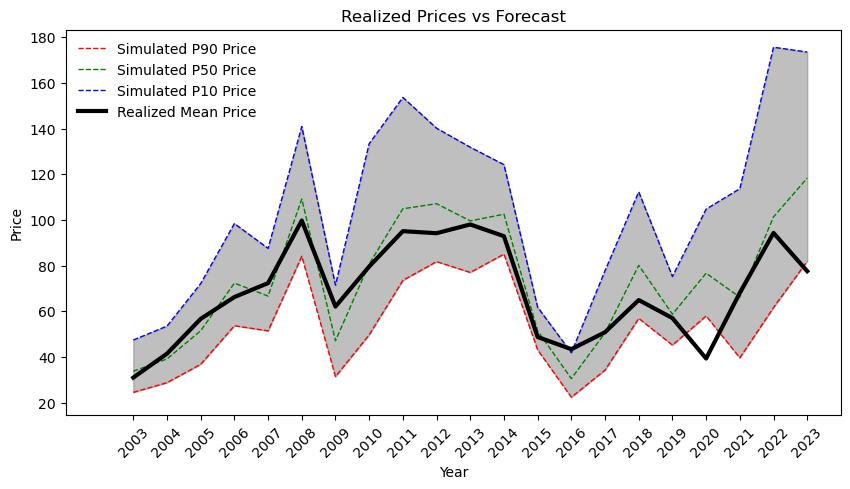

In [161]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(prices.index, prices['Sim_P90'], 'r--', lw=1, label='Simulated P90 Price')
ax.plot(prices.index, prices['Sim_P50'], 'g--', lw=1, label='Simulated P50 Price')
ax.plot(prices.index, prices['Sim_P10'], 'b--', lw=1, label='Simulated P10 Price')
ax.fill_between(prices.index.astype(float), prices['Sim_P10'].astype(float), prices['Sim_P90'].astype(float), color='gray', alpha=0.5)
ax.plot(prices.index, prices['Actual_Mean'], 'k-', lw=3, label='Realized Mean Price')
ax.legend(loc='best', frameon=False)
ax.set(title='Realized Prices vs Forecast', xlabel='Year', ylabel='Price', xlim=(2001, 2024))
ax.set_xticks(prices.dropna().index)
ax.set_xticklabels(prices.dropna().index, rotation=45)
plt.show()